In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! nvidia-smi

Wed Apr 14 16:54:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# clone HRNet official implemetation
! git clone https://github.com/microsoft/human-pose-estimation.pytorch.git
! mv human-pose-estimation.pytorch ${POSE_ROOT}

In [ ]:
% cd /content/drive/MyDrive/Myntra_fashion_recommendation/'${POSE_ROOT}'/

/content/drive/MyDrive/Myntra_fashion_recommendation/${POSE_ROOT}


In [ ]:
! pip install -r requirements.txt
! cd lib/ && make

In [ ]:
# INSTALL COCOAPI
! git clone https://github.com/cocodataset/cocoapi.git $COCOAPI
! cd '$COCOAPI'/PythonAPI && python3 setup.py install --user

In [ ]:
def bbox_center_scale(box, image_width, image_height):
    x, y, w, h = box[:4]
    return get_center_scale(x, y, w, h, image_width, image_height)

def get_center_scale(x, y, w, h, image_width, image_height):
    center = np.zeros((2), dtype=np.float32)
    center[0] = x + w * 0.5
    center[1] = y + h * 0.5
    
    aspect_ratio = image_width * 1.0 / image_height
    pixel_std = 200

    if w > aspect_ratio * h:
        h = w * 1.0 / aspect_ratio
    elif w < aspect_ratio * h:
        w = h * aspect_ratio
    scale = np.array(
        [w * 1.0 / pixel_std, h * 1.0 / pixel_std],
        dtype=np.float32)
    if center[0] != -1:
        scale = scale * 1.25

    return center, scale

In [ ]:
import os.path as osp
import os
import sys

# add custom modules to system path
def add_path(path):
    if path not in sys.path:
        sys.path.insert(0, path)

this_dir = osp.dirname('/content/drive/My Drive/Myntra_fashion_recommendation/${POSE_ROOT}/pose_estimation/_init_paths.py')

lib_path = osp.join((os.sep).join(this_dir.split(os.sep)[:-1]), 'lib')
add_path(lib_path)

# Inference

Loading network.....
Network successfully loaded
IMAGE:000001.jpg
FULL POSE


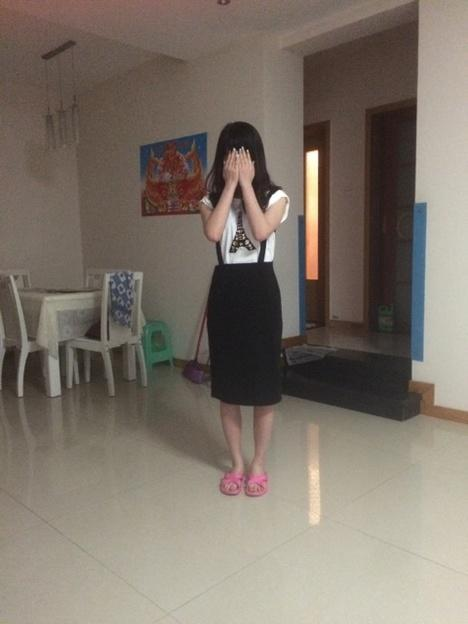

IMAGE:000007.jpg
FULL POSE


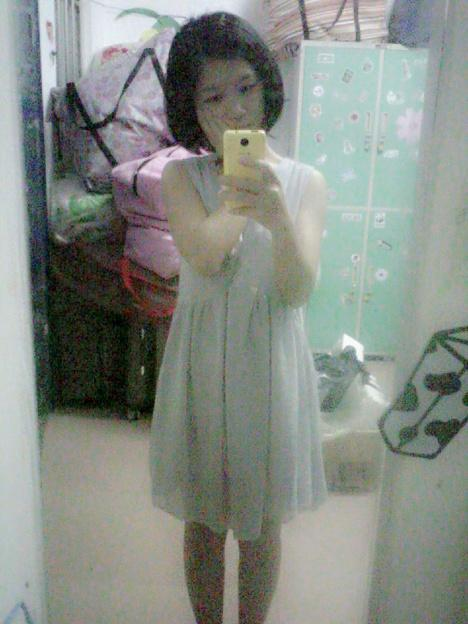

IMAGE:000009.jpg
NOT A FULL POSE


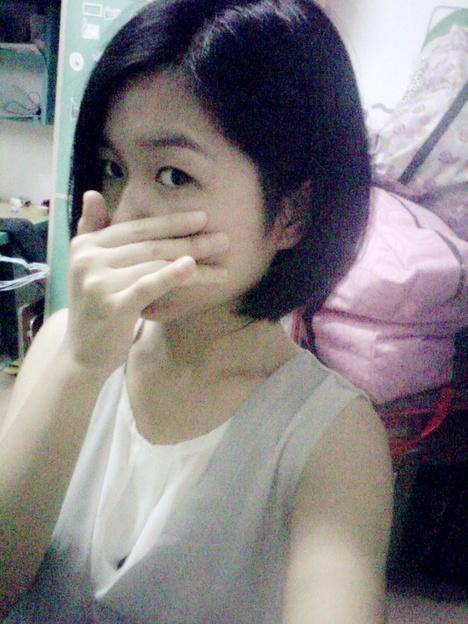

IMAGE:000002.jpg
NOT A FULL POSE


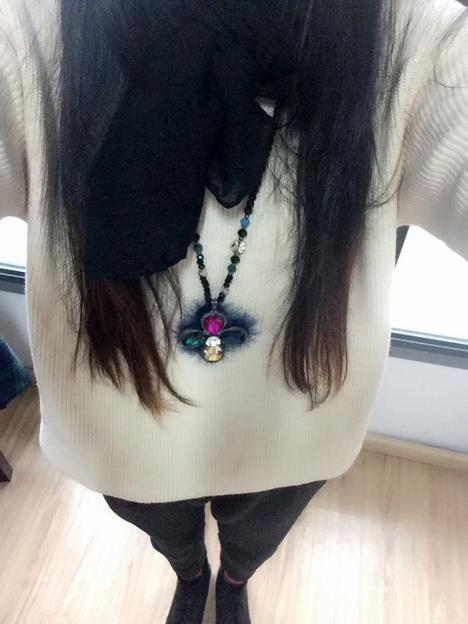

IMAGE:000020.jpg
FULL POSE


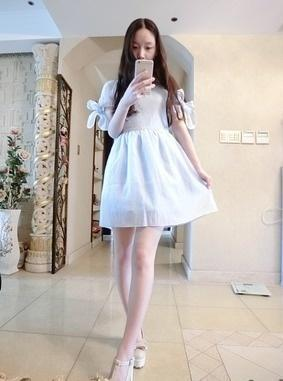

IMAGE:000008.jpg
NOT A FULL POSE


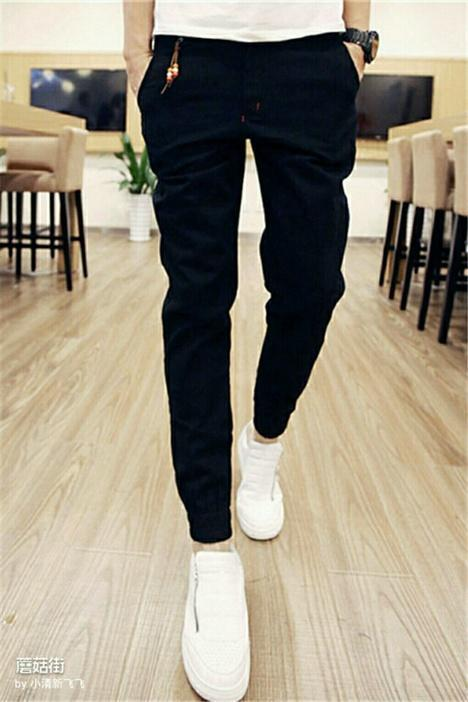

In [17]:
import warnings
warnings.filterwarnings('ignore')

import os
from easydict import EasyDict as edict
import torch
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms

from core.config import config
from core.config import update_config
from core.inference import get_final_preds
from core.loss import JointsMSELoss
from utils.transforms import *
from detector.yolo.human_detector import human_bbox_get
from detector.yolo.human_detector import load_model

import cv2
import models
import numpy as np
from google.colab.patches import cv2_imshow

# network configuration
cfg = '/content/drive/MyDrive/Myntra_fashion_recommendation/${POSE_ROOT}/experiments/coco/resnet50/256x192_d256x3_adam_lr1e-3.yaml'
# update config
update_config(cfg)

# cudnn related setting
cudnn.benchmark = True
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.enabled = True

# load resnet model
model = eval('models.'+config.MODEL.NAME+'.get_pose_net')(
    config, is_train=False
)
# YOLO V3 detection model
yolo_model = load_model() 

# load resnet weights
model_state_file = '/content/drive/MyDrive/Myntra_fashion_recommendation/${POSE_ROOT}/models/pytorch/pose_coco/pose_resnet_50_256x192.pth.tar'
model.load_state_dict(torch.load(model_state_file))

gpus = [int(i) for i in config.GPUS.split(',')]
model = torch.nn.DataParallel(model, device_ids=gpus).cuda()

# define loss function (criterion) and optimizer
criterion = JointsMSELoss(
    use_target_weight=config.LOSS.USE_TARGET_WEIGHT
).cuda()

## INFERENCE
image_dir ='/content/drive/MyDrive/Myntra_fashion_recommendation/${POSE_ROOT}/data/coco/images/demo_images/'
for root_dir, _ , images in os.walk(image_dir):
  for image_file in images:
    print(f'IMAGE:{image_file}')
    data_numpy = cv2.imread(root_dir+os.sep+image_file, cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
    # data_numpy = cv2.resize(data_numpy, (512, 512))
    if data_numpy is None:
        raise ValueError('Fail to read {}'.format(image_file))

    # detect human bbox
    box, scores = human_bbox_get(data_numpy, yolo_model)
    # check if anything detected
    if len(box)>0:
      c, s = bbox_center_scale(box[0], data_numpy.shape[0], data_numpy.shape[1])
      r = 0

      trans = get_affine_transform(c, s, r, config.MODEL.IMAGE_SIZE)
      input = cv2.warpAffine(
          data_numpy,
          trans,
          (int(config.MODEL.IMAGE_SIZE[0]), int(config.MODEL.IMAGE_SIZE[1])),
          flags=cv2.INTER_LINEAR)


      transform = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
          ])
      input = transform(input).unsqueeze(0)

      # switch to evaluate mode
      model.eval()
      with torch.no_grad():
          # compute output heatmap
          output = model(input)
          
          # compute coordinate
          preds, maxvals = get_final_preds(
              config, output.clone().cpu().numpy(), np.asarray([c]), np.asarray([s]))

          thresh=0.6
          # check if keypoint predictions is greater than threshold
          if maxvals[0][0]>thresh and maxvals[0][1]>thresh and maxvals[0][2]>thresh and maxvals[0][3]>thresh and \
          maxvals[0][4]>thresh and maxvals[0][15]>thresh and maxvals[0][16]>thresh:
            print("FULL POSE")
          else:
            print("NOT A FULL POSE")
        
      # display imahege
      cv2_imshow(data_numpy)
    else:
      print("NOT A FULL POSE")
      cv2_imshow(data_numpy)